# Setup 

In [11]:
from nltk.corpus import wordnet as wn
import nltk
import pandas as pd
from itertools import combinations
import statistics
import seaborn as sns
import numpy as np
from get_tags import *

ModuleNotFoundError: No module named 'get_tags'

In [ ]:
"""
    Checking words that might have spelling errors
    And manually correct them (used for the manual entries)
"""

path = './Tags.xlsx'
df_manual = pd.read_excel(path)

path = './all_segment.csv'
df_google = pd.read_csv(path)

i=0
for video in list(df_manual['Video']):
    df = df_google.loc[df_google['Name']==video]
    words = cleanWords(df['VideoLabel'].tolist())
    
    for word in words:
        try:
            w = wn.synsets(word)[0]
        except:
            i+=1
            print(word, '------------', video)
            
print('Total Words missing:', i)

# Fonctions 

In [21]:
dog = wn.synsets('dog')[0]
cat = wn.synsets('cat')[0]
print('similarity:', dog.wup_similarity(cat))

wn._lcs_ic(dog, cat, verbose=False)

similarity: 0.8571428571428571


AttributeError: 'WordNetCorpusReader' object has no attribute '_lcs_ic'

In [6]:
"""
Function that take a list of word and return descriptive statistics about this group of words
"""

def descriptive_stats_similarity(word_list):
    values = [] # Add all value of similarity to the list
    result = {}
    for pair in combinations(word_list, 2):
        
        try:
            w1 = wn.synsets(pair[0])[0]
            w2 = wn.synsets(pair[1])[0]
            similarity = w1.wup_similarity(w2)

            if similarity != None:
                values.append(similarity)

            else: # If value is none (no similarity, add 0)
                values.append(0.00)
                
        except:
            pass
#             print("{} and {} --- This combinaison may contain an error".format(pair[0], pair[1]))
        
    try:
        result['Mean'] = round(statistics.mean(values),3)
        result['STD'] = round(statistics.stdev(values),3)
        result['Variance'] = round(statistics.variance(values),3)
        result['min'] = round(min(values),3)
        result['max'] = round(max(values),3)
        result['count'] =  len(values)

    
    except:
        print('This video contain only one word, no similarity')
        result = {'Mean':np.nan, 'STD':np.nan, 'Variance':np.nan, 'min':np.nan, 'max':np.nan, 'count':len(values)}

    return result

# Exemple of retun with the words ['apple', 'tree', 'car', 'monkey']
print('Exemple:', descriptive_stats_similarity(['apple', 'tree', 'car', 'monkey']))

Exemple: {'Mean': 0.386, 'STD': 0.07, 'Variance': 0.005, 'min': 0.333, 'max': 0.522, 'count': 6}


# Analysis #1 
## Descriptive comparaison between Google and Manual Tags

Using the function above, I obtained the mean of similarity of each video for (1) google API and (2) manual tags. I then created a distribution graph (x=manual and y=google) with different colors for the type of video. I also created a graph with anova and t-test to see the distribution between google and manual tags. 

In [4]:
"""
    create a dataframe with
    - video type
    - video name
    - Mean of similarity based on google API
    - Mean of similarity based on my own tags
"""

# import data
words_google, _, vid_google = use_GoogleAPI_Tag('all_segment.csv')
words_manual, _, vid_manual = use_Manual_Tag()

# df to store data
df_result = pd.DataFrame(columns=['Type','Video', 'Manual', 'Google'])

for vid in vid_manual:    
    
    # get a list of video from Manual Annotation
    manual_index = vid_manual.index(vid)   
    words = words_manual[manual_index].split()
    manual_mean = descriptive_stats_similarity(words)['Mean']
    
    # get a list of video from google Annoation
    try:
        google_index = vid_google.index(vid)
        words = words_google[google_index].split()
        google_mean = descriptive_stats_similarity(words)['Mean']
    except: 
        print(vid, 'do not exist in google tags')
        google_mean = np.NaN
    
    df_result = df_result.append({'Type':int(vid[0]) ,'Video':video, 'Manual':manual_mean, 'Google':google_mean}, ignore_index=True)

Using: C:/Users/ramme/Dev/Analyse-Maitrise/Videos/result/GoogleAPI_results/all_segment.csv
This video contain only one word, no similarity
1Neutral_frigo do not exist in google tags
This video contain only one word, no similarity
1Neutral_officework do not exist in google tags
This video contain only one word, no similarity
This video contain only one word, no similarity
2Funny Sillywalk do not exist in google tags
2Funny weddingcake GA.mp4 do not exist in google tags
This video contain only one word, no similarity
2Marie_Oktoberfest.mp4 do not exist in google tags
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
2vid33.mp4 do not exist in google tags
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This 

In [7]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    150 non-null    object 
 1   Video   150 non-null    object 
 2   Manual  150 non-null    float64
 3   Google  129 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.8+ KB


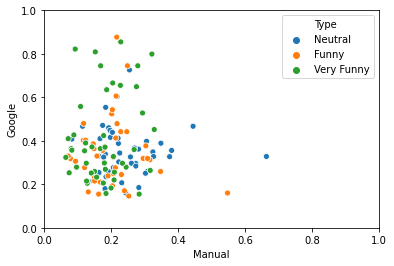

In [8]:
import matplotlib.pyplot as plt

df = df_result.dropna()

df = df.replace({'Type': {1: 'Neutral', 2: 'Funny', 3:'Very Funny'}})
ax = sns.scatterplot(x="Manual", y="Google", data=df, hue='Type')
plt.ylim(0, 1);
plt.xlim(0, 1);

No Title 

p = 0.161359
There's no difference in the groups

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
  Funny    Neutral   0.0025    0.9 -0.0811 0.0861  False
  Funny Very Funny   0.0586 0.2204 -0.0246 0.1418  False
Neutral Very Funny   0.0561 0.2327  -0.025 0.1373  False
--------------------------------------------------------


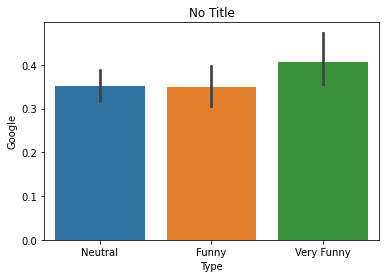

In [10]:
import pandas as pd 
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import MultiComparison

def Anova_Type(df, rating, group='VideoType', title='No Title', alpha=0.05):
    
    # Settings for the X axis
    type_value = {1:'Neutral', 2:'Funny', 3:'Very Funny'}
    df=df.replace({group: type_value})  
    order = ['Neutral', 'Funny', 'Very Funny']

    bloc1 = list(df.loc[df[group] == 'Neutral'][rating])
    bloc2 = list(df.loc[df[group] == 'Funny'][rating])
    bloc3 = list(df.loc[df[group] == 'Very Funny'][rating])

    print(title, '\n')

    # Create a barplot

    ax=sns.barplot(x=group, y=rating, data=df, order = order).set_title(title)

    # Anova
    k, p = stats.f_oneway(bloc1, bloc2, bloc3)

    if p < alpha:
        print("p = {:g}*".format(p))
        print("There's a difference in at least one groups\n")
    else:
        print("p = {:g}".format(p))
        print("There's no difference in the groups\n")

    # Multiple Comparaison

    mc = MultiComparison(df[rating], df[group])
    mc_results = mc.tukeyhsd()
    print(mc_results)

    
df = df_result.dropna()
Anova_Type(df,'Manual' ,'Type')



#  Analysis #2
## Generate a dataframe to use in ML 

Create a dataframe where each colomn is a video and we have the mean, std, var, min, max and count of each similarity

In [103]:
def similarity_computed(words, type_vid, vids, method):
    
    df_result = pd.DataFrame(columns=['Video', 'Method', 'Mean', 'STD', 'Variance', 'min', 'max'])

    for vid in vids:    
        index = vids.index(vid)   
        try:
            words_list = words[index].split() # change string to list of words
        except:
            words_list = list(words[index])
            
        data = descriptive_stats_similarity(words_list)
        
        if vid[-4:] == '.mp4':
             data['Video'] = vid[:-4]
        else:
            data['Video'] = vid
            
        data['Method'] = method
        df_result = df_result.append(data, ignore_index=True)
    
    return df_result

In [104]:
"""
    create a dataframe with
    - video name
    - Mean, STD, var, min, max, count of Google API
    - Mean, STD, var, min, max, count of Manual Tags
"""

# import data
words_google, type_google, vid_google = use_GoogleAPI_Tag('all_segment.csv')
words_manual, type_manual, vid_manual = use_Manual_Tag()

similarity_computed(words_google, type_google, vid_google, 'Google').to_csv('./similarity_google_13082020.csv')
similarity_computed(words_manual, type_manual, vid_manual, 'Manual').to_csv('./similarity_manual_13082020.csv')

Using: C:/Users/ramme/Dev/Analyse-Maitrise/Videos/result/GoogleAPI_results/all_segment.csv
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity
This video contain only one word, no similarity


In [ ]:
words_google, type_google, vid_google = use_GoogleAPI_Tag('all_segment.csv')